In [2]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
from sklego.linear_model import LowessRegression
import statsmodels.api as sm
from scipy.stats import ttest_ind, skewtest, boxcox
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

### Reading in from external source

In [14]:
table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [15]:
table.head()

,miRNA,Healthy control 1,Healthy control 2,Healthy control 3,Healthy control 4,Healthy control 5,Healthy control 6,Healthy control 7,Healthy control 8,Healthy control 9,...,OD 874,OD 875,OD 876,OD 877,OD 878,OD 879,OD 880,OD 881,OD 882,OD 883
0,hsa-let-7a-3p,5.98879,7.380677,7.672810,6.613076,11.527153,6.802500,5.880256,11.543763,7.154083,...,8.581974,6.405327,9.592039,8.458054,5.231669,9.144063,5.153392,11.459711,20.250156,15.120563
1,hsa-let-7a-5p,2439.69262,20989.575296,31645.820205,39785.067842,31230.353897,38051.171659,958.540489,26414.154148,16586.484823,...,31887.613521,10253.447955,68895.120418,26718.589860,124.858642,63857.761619,856.267323,27600.463068,19488.570664,22283.226524
2,hsa-let-7b-3p,11.78032,15.448649,13.338528,13.885756,19.288142,15.084712,7.185237,16.824500,16.196026,...,21.361416,12.543551,20.264019,14.556385,6.220702,24.859740,7.389210,18.877957,37.245982,22.464665
3,hsa-let-7b-5p,1040.20962,18504.673331,7955.195696,24977.608432,39978.077062,37595.019787,1359.028489,4014.889159,16931.607811,...,4849.241869,1257.587019,10516.197060,10810.224198,479.614342,8749.304276,2202.739323,4600.033750,5339.333966,4008.972424
4,hsa-let-7c-3p,NaN,6.671031,6.848874,5.930795,10.633752,6.246456,5.475492,9.762535,7.198736,...,9.122395,6.682408,10.109299,7.948756,5.192131,8.088978,4.853054,10.748838,19.576433,13.555511


In [16]:
table = table.loc[:, np.array("miRNA" in v or "Healthy" in v or "LCa" in v for v  in table.columns)]

### Get controls

In [17]:
sick = np.array(["LCa" in t for t in list(table)[1:]])
controls = 1 - sick

In [18]:
sum(sick)

606

### Drop NAN

In [19]:
table = table.dropna(0)

C:\Users\OLEFRE~1\AppData\Local\Temp/ipykernel_9368/338023607.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(0)


### T-test

In [20]:
X = table.iloc[:, 1:].transpose()

In [21]:
X

,0,1,2,3,5,6,7,8,9,10,...,2536,2537,2538,2541,2542,2544,2545,2546,2547,2548
Healthy control 1,5.988790,2439.692620,11.780320,1040.209620,194.282820,7.189860,766.731620,5.351587,8.520220,12.028410,...,4.573345,5.137256,5.491173,4.746277,60.57162,20.96443,5.403362,13.697740,5.110449,11.07720
Healthy control 2,7.380677,20989.575296,15.448649,18504.673331,3965.491812,14.408822,5312.466200,6.295542,21.514407,13.892107,...,5.204015,5.192455,5.732409,5.220955,191.81740,84.03203,5.327982,213.873700,5.773773,111.66310
Healthy control 3,7.672810,31645.820205,13.338528,7955.195696,2217.527520,20.839338,7063.847958,6.827632,25.900714,13.863076,...,6.479215,6.616299,6.557615,5.990099,417.67460,159.89260,6.421957,184.569600,6.529618,197.37750
Healthy control 4,6.613076,39785.067842,13.885756,24977.608432,5927.803928,8.536264,11272.834600,6.348113,28.759241,11.372788,...,5.746677,5.548189,6.290292,5.307264,1573.82700,208.98780,5.693892,65.718150,6.206826,78.27406
Healthy control 5,11.527153,31230.353897,19.288142,39978.077062,9297.550922,17.881494,8031.057737,10.243077,28.621188,17.654802,...,9.177522,9.468003,9.567642,8.611114,452.85390,125.21560,8.883525,140.656100,8.768461,103.70190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LCa 602,6.630315,14162.449093,15.723833,8783.679093,1469.398093,14.214003,3092.085093,6.302444,13.702293,13.905533,...,4.960116,5.736185,5.983633,4.914857,424.69410,100.07650,5.711783,29.032590,5.653348,20.05251
LCa 603,7.453972,5201.956430,16.366350,13082.113940,3018.114985,14.961406,1188.150099,6.501082,13.306738,15.428598,...,6.545988,6.846935,7.094767,6.184647,12.38445,22.04146,6.820604,8.885176,6.326701,37.88817
LCa 604,6.983482,18575.975345,16.554675,28722.812860,5012.765042,25.232413,3565.379494,6.092412,17.952115,14.885612,...,5.785760,6.216784,6.131028,5.597585,38.32273,69.05585,6.077839,40.444190,5.603081,52.21929
LCa 605,6.851022,10716.217321,11.882892,7241.941542,1693.282841,13.313735,3230.107094,6.054958,17.925160,11.668931,...,5.556342,6.039240,6.153074,5.965303,301.94230,42.11646,5.853967,75.401670,5.983184,100.36380


In [22]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [23]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [24]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [25]:
table.iloc[lowest, 0], pvalues

(669     hsa-miR-33b-3p
 170       hsa-miR-1290
 808    hsa-miR-374c-5p
 343     hsa-miR-197-3p
 806    hsa-miR-374b-5p
 Name: miRNA, dtype: object,
 array([1.58606926e-36, 8.98444609e-35, 2.47992908e-34, 1.53619046e-33,
        5.45921846e-32]))

### F-test

In [26]:
t3 = table.iloc[:, 1:].transpose()

In [27]:
f, p = f_classif(t3, sick)

### ANOVA

In [28]:
t3

,0,1,2,3,5,6,7,8,9,10,...,2536,2537,2538,2541,2542,2544,2545,2546,2547,2548
Healthy control 1,5.988790,2439.692620,11.780320,1040.209620,194.282820,7.189860,766.731620,5.351587,8.520220,12.028410,...,4.573345,5.137256,5.491173,4.746277,60.57162,20.96443,5.403362,13.697740,5.110449,11.07720
Healthy control 2,7.380677,20989.575296,15.448649,18504.673331,3965.491812,14.408822,5312.466200,6.295542,21.514407,13.892107,...,5.204015,5.192455,5.732409,5.220955,191.81740,84.03203,5.327982,213.873700,5.773773,111.66310
Healthy control 3,7.672810,31645.820205,13.338528,7955.195696,2217.527520,20.839338,7063.847958,6.827632,25.900714,13.863076,...,6.479215,6.616299,6.557615,5.990099,417.67460,159.89260,6.421957,184.569600,6.529618,197.37750
Healthy control 4,6.613076,39785.067842,13.885756,24977.608432,5927.803928,8.536264,11272.834600,6.348113,28.759241,11.372788,...,5.746677,5.548189,6.290292,5.307264,1573.82700,208.98780,5.693892,65.718150,6.206826,78.27406
Healthy control 5,11.527153,31230.353897,19.288142,39978.077062,9297.550922,17.881494,8031.057737,10.243077,28.621188,17.654802,...,9.177522,9.468003,9.567642,8.611114,452.85390,125.21560,8.883525,140.656100,8.768461,103.70190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LCa 602,6.630315,14162.449093,15.723833,8783.679093,1469.398093,14.214003,3092.085093,6.302444,13.702293,13.905533,...,4.960116,5.736185,5.983633,4.914857,424.69410,100.07650,5.711783,29.032590,5.653348,20.05251
LCa 603,7.453972,5201.956430,16.366350,13082.113940,3018.114985,14.961406,1188.150099,6.501082,13.306738,15.428598,...,6.545988,6.846935,7.094767,6.184647,12.38445,22.04146,6.820604,8.885176,6.326701,37.88817
LCa 604,6.983482,18575.975345,16.554675,28722.812860,5012.765042,25.232413,3565.379494,6.092412,17.952115,14.885612,...,5.785760,6.216784,6.131028,5.597585,38.32273,69.05585,6.077839,40.444190,5.603081,52.21929
LCa 605,6.851022,10716.217321,11.882892,7241.941542,1693.282841,13.313735,3230.107094,6.054958,17.925160,11.668931,...,5.556342,6.039240,6.153074,5.965303,301.94230,42.11646,5.853967,75.401670,5.983184,100.36380


In [29]:
X = np.array(sick).reshape(-1, 1)

In [30]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [31]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.017835140761690446

### Mean-variance-plot

In [32]:
mirnas = table.iloc[:, 0]
table = table.iloc[:, 1:]

In [33]:
table = table.transpose()

In [34]:
np.mean(table)

0           8.698312
1       21509.998919
2          17.238233
3       14910.120551
5        3325.690826
            ...     
2544      113.034860
2545        7.389639
2546       78.029518
2547        7.773996
2548       74.078543
Length: 1183, dtype: float64

In [35]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [36]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

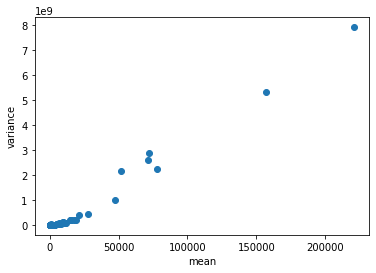

In [37]:
mean_variance_plot(table)

In [38]:
log_table = np.log2(table)

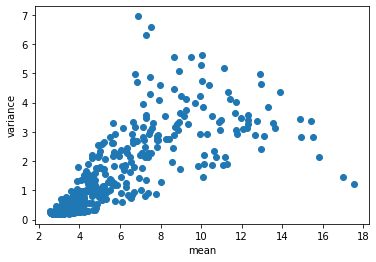

In [39]:
mean_variance_plot(log_table)

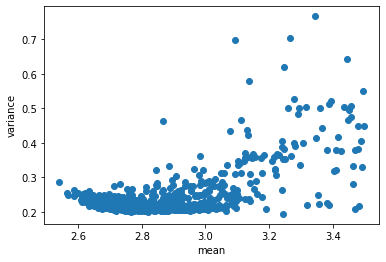

In [40]:
mean_variance_plot(log_table.loc[:, np.mean(log_table) < 3.5])

In [41]:
mask = np.mean(log_table) > 3.2
mirnas = mirnas[mask]
log_table = log_table.loc[:, mask]

### Loess regression

In [42]:
lowess = LowessRegression(sigma=1, span=0.1)

In [43]:
means, variances = get_means_and_variances(log_table)
lowess.fit(means.to_numpy().reshape(-1,1), variances)

LowessRegression(span=0.1)

In [44]:
x_axis = np.linspace(-2, 14, 100)
y_axis = lowess.predict(x_axis.reshape(-1,1))

[]

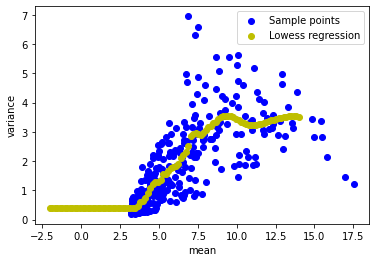

In [45]:
plt.scatter(means, variances, color="b")
plt.scatter(x_axis, y_axis, color="y")
plt.xlabel("mean")
plt.ylabel("variance")
plt.legend(["Sample points", "Lowess regression"])
plt.plot()

### Lowess normalization

In [46]:
adj_var = lowess.predict(means.to_numpy().reshape(-1, 1))

In [47]:
log_table /= np.sqrt(adj_var)

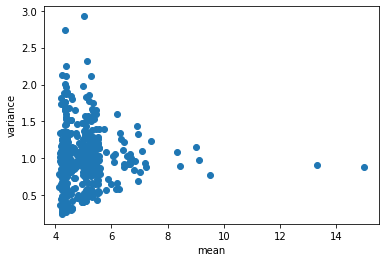

In [48]:
mean_variance_plot(log_table)

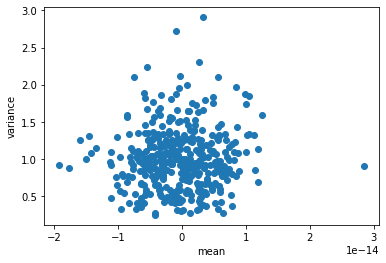

In [49]:
norm_log_table = log_table - np.mean(log_table)
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))
mean_variance_plot(norm_log_table)

In [50]:
norm_log_table = log_table - np.mean(log_table)

In [51]:
norm_log_table /= np.mean(np.std(norm_log_table))

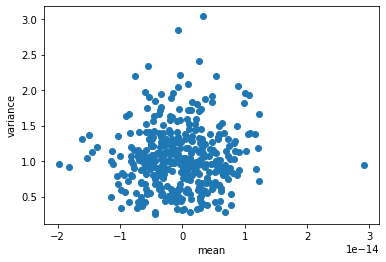

In [52]:
mean_variance_plot(norm_log_table)

### PCA

In [53]:
pca = decomposition.PCA(n_components=10)

In [54]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [55]:
pca.explained_variance_ratio_

array([0.58078646, 0.10997117, 0.05605678, 0.04542249, 0.02142224,
       0.01940129, 0.01557878, 0.01239268, 0.012188  , 0.00951069])

In [56]:
components = pca.transform(norm_log_table)

In [57]:
components

array([[ 25.77472328,  -4.14117952,   1.55314691, ...,   1.1602003 ,
         -0.18630459,  -0.42546996],
       [-10.11765159,  -4.14504529,  -7.7990883 , ...,   6.76965716,
         -1.79270946,   2.3013167 ],
       [-11.74284592,  -8.44551888,  -3.76542643, ...,  -0.63104288,
          1.2906096 ,   3.08875415],
       ...,
       [ -2.44830061,  -2.80935606,  -7.82514775, ...,   2.52783692,
          3.9572109 ,   2.636944  ],
       [ -8.48241883,   0.06760335,  -4.18616057, ...,   2.16693153,
          1.62585694,  -0.23296607],
       [ -0.79032667,  -5.79150286,  -6.8807782 , ...,   6.31833045,
          1.73284993,   1.00412167]])

In [58]:
sum(controls)

964

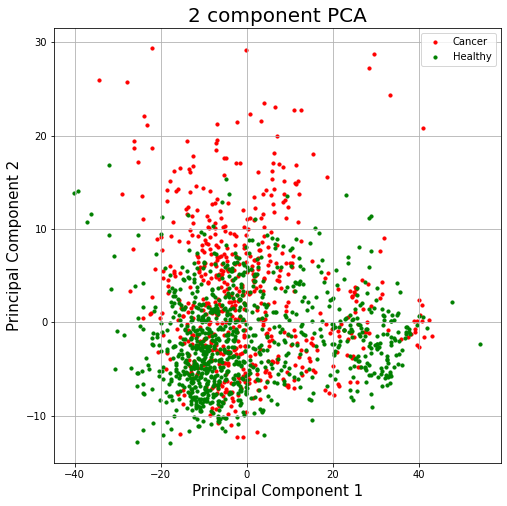

In [59]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [60]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

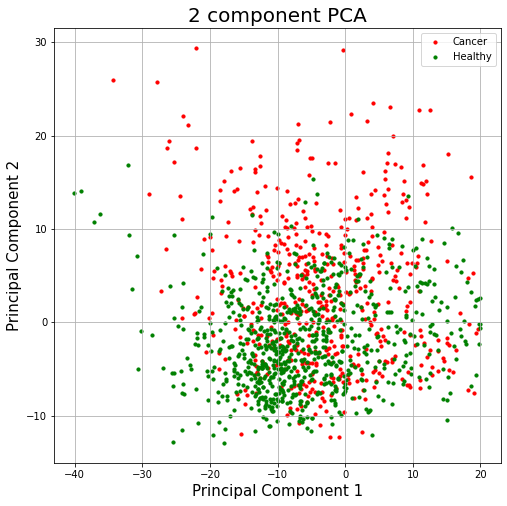

In [61]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### XGBoost

In [62]:
X_train, X_test, y_train, y_test = train_test_split(norm_log_table, controls, test_size=0.33, random_state=42)

In [63]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[16:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\Ole Fredrik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


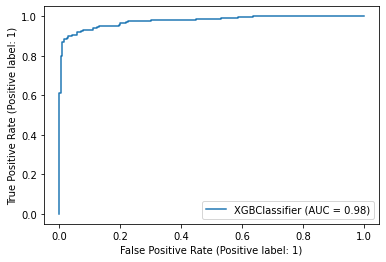

In [64]:
plot_roc_curve(model, X_test, y_test)

### Exporting data

In [65]:
from Scripts import converters

In [66]:
sequences = converters.canonical_to_seq(mirnas)

In [67]:
norm_log_table.columns = sequences
norm_log_table["cancer"] = sick
norm_log_table.head()

,UGAGGUAGUAGGUUGUAUAGUU,CUAUACAACCUACUGCCUUCCC,UGAGGUAGUAGGUUGUGUGGUU,UGAGGUAGUAGGUUGUAUGGUU,CUAUACGACCUGCUGCCUUUCU,AGAGGUAGUAGGUUGCAUAGUU,UGAGGUAGGAGGUUGUAUAGUU,CUAUACAAUCUAUUGCCUUCCC,UGAGGUAGUAGAUUGUAUAGUU,UGAGGUAGUAGUUUGUACAGUU,...,CAAAGUGCUGUUCGUGCAGGUAG,UGUGCGCAGGGAGACCUCUCCC,UGGGGAGCUGAGGCUCUGGGGGUG,AAGGCAGGGCCCCCGCUCCCC,UCUUCUCUGUUUUGGCCAUGUG,UUUGGCACUAGCACAUUUUUGCU,UGAGGUAGUAAGUUGUAUUGUU,AACCCGUAGAUCCGAUCUUGUG,CACCCGUAGAACCGACCUUGCG,cancer
Healthy control 1,-1.292483,-0.569387,-1.680382,-1.854255,-1.298409,-1.221968,-1.346920,-0.437675,-1.205962,-1.071660,...,-1.057200,-0.624479,-0.916349,-1.078083,-1.660707,-0.934106,-1.264512,-1.488856,-1.735063,False
Healthy control 2,0.389889,-0.076203,0.581650,0.615721,0.032105,0.341623,-0.006728,-0.163505,0.409956,0.245370,...,0.357333,0.017599,-0.023297,0.249493,1.068434,0.057345,0.261411,1.634556,0.874314,False
Healthy control 3,0.710846,-0.343388,-0.081729,0.139723,0.738353,0.571786,0.261733,-0.167486,0.777252,0.639533,...,0.274423,-0.631595,0.013453,0.145580,1.499954,0.726638,0.968450,1.467075,1.517604,False
Healthy control 4,0.889770,-0.270241,0.817359,0.944954,-0.969877,0.949345,0.413202,-0.544352,1.150495,1.410342,...,1.121544,-0.409013,0.681191,-0.148253,0.236697,1.867613,1.262753,0.293416,0.473105,False
Healthy control 5,0.700515,0.327615,1.186965,1.313556,0.445374,0.675445,0.406240,0.292693,0.688697,0.414223,...,0.678903,0.538991,0.909889,0.266447,0.995835,0.796192,0.699765,1.158265,0.790784,False


In [68]:
norm_log_table.to_csv("../TransformedData/Fehlmann2020_cleaned.csv", index=False)